In [1]:
import numpy as np

# Load the data
X = np.load('archive-2/Sign-language-digits-dataset/X.npy')

# flatten the X matrix
X = X.reshape(X.shape[0], -1)

Y = np.zeros((X.shape[0], 10))
Y[0:204, 9] = 1
Y[204:409, 0] = 1
Y[409:615, 7] = 1
Y[615:822, 6] = 1
Y[822:1028, 1] = 1
Y[1028:1236, 8] = 1
Y[1236:1443, 4] = 1
Y[1443:1649, 3] = 1
Y[1649:1855, 2] = 1
Y[1855:, 5] = 1

indices = np.argmax(Y, axis=1)
Y = np.expand_dims(indices, axis=1)

In [2]:
# Split data into train and test

import numpy as np
from tensorflow.keras.utils import to_categorical

data = np.concatenate((Y, X), axis=1)

np.random.shuffle(data)

# Extract features (pixel values) and labels
X = data[:, 1:]  # Pixel values
y = data[:, 0]   # Labels

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=10)  # Assuming you have 10 classes (digits 0 to 9)

# Now, 'X' contains the pixel values, and 'y_one_hot' contains the one-hot encoded labels

# from sklearn.decomposition import PCA

# pca = PCA(n_components=2025)
# X = pca.fit_transform(X)

# Split the data into training, validation and testing sets (you may need to adjust the split ratio)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.1, random_state=42)

# Now, you can use X_train and y_train to train your neural network, and X_test and y_test for testing.

2023-11-07 11:29:16.513198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import cv2
import numpy as np

def augment_data(images, labels, num_augmented_samples=1):
    augmented_images = []
    augmented_labels = []
    
    center = (32, 32)
    scale = 1.0

    for i in range(len(images)):
        image = images[i]
        label = labels[i]

        for _ in range(num_augmented_samples):
            augmented_image = image.reshape(64, 64)

            # Randomly rotate the image (between -10 and 10 degrees)
            angle = np.random.randint(-10, 10)
            M = cv2.getRotationMatrix2D(center, angle, scale)
            augmented_image = cv2.warpAffine(augmented_image, M, (64, 64))

            # Randomly flip the image horizontally
            if np.random.choice([True, False]):
                augmented_image = np.fliplr(augmented_image)

            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)


X_aumented, y_aumented = augment_data(X_train, y_train, num_augmented_samples=5)
X_aumented = X_aumented.reshape(X_aumented.shape[0], -1)
X_train = np.concatenate((X_train, X_aumented), axis=0)
y_train = np.concatenate((y_train, y_aumented), axis=0)


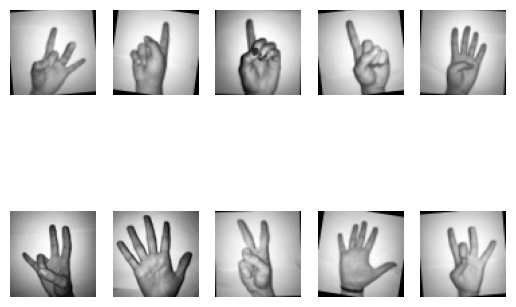

In [4]:
# plot teh first augmented image
import matplotlib.pyplot as plt
import random

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[random.randint(0, len(X_train))].reshape(64, 64), cmap='gray')
    plt.axis('off')

plt.show()

In [5]:
import tensorflow as tf
import numpy as np

# Function to build the model
def build_model(input_dim, hidden_layer_sizes, output_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    
    for hidden_units in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(hidden_units, activation='relu'))
    
    model.add(tf.keras.layers.Dense(output_dim, activation='softmax'))
    return model

# Function to perform feed-forward, calculate cost, do backpropagation, and return gradients
def train_step(model, X_train, y_train):
    with tf.GradientTape() as tape:
        y_pred = model(X_train, training=True)
        loss_value = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_train, y_pred))
    
    grads = tape.gradient(loss_value, model.trainable_weights)
    
    return loss_value, grads

# Function to perform gradient descent with a custom model
def custom_gradient_descent(model, X_train, y_train, learning_rate, num_iterations):
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    cost_history = []
    for i in range(num_iterations):
        loss_value, grads = train_step(model, X_train, y_train)
        
        # Apply gradients
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        cost_history.append(loss_value.numpy())
        
        if (i + 1) % 100 == 0:
            print(f'Iteration {i+1}/{num_iterations}, Loss: {loss_value.numpy()}')
    
    return cost_history, grads

# Example usage
input_dim = 4096
hidden_layer_sizes = [1000, 500, 100, 50]
output_dim = 10
learning_rate = 0.01
num_iterations = 200

# Create the model
model = build_model(input_dim, hidden_layer_sizes, output_dim)

# Train the model using custom gradient descent
cost_history, gradients = custom_gradient_descent(model, X_train, y_train, learning_rate, num_iterations)

2023-11-07 11:29:19.521979: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Iteration 100/200, Loss: 2.161496877670288
Iteration 200/200, Loss: 2.03833270072937


In [6]:
# compute the accuracy on test data
y_pred = model.predict(X_test)
y_pred_one_hot = np.argmax(y_pred, axis=1)
y_test_one_hot = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred_one_hot == y_test_one_hot)
print(f'Accuracy: {accuracy}')


7/7 [==============================] - 0s 24ms/step
Accuracy: 0.2995169082125604


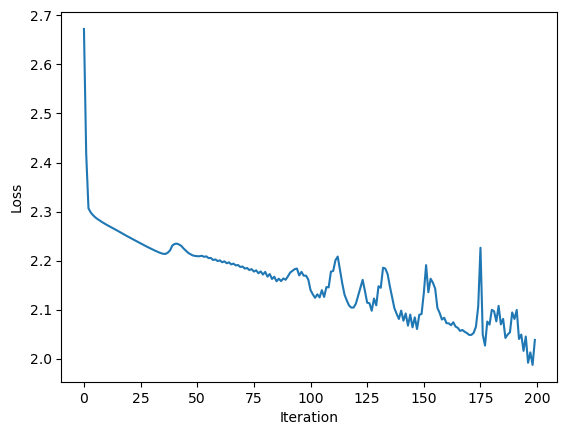

In [7]:
# plot the loss over epochs
import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

(207, 10)
1/1 [==============================] - 0s 56ms/step


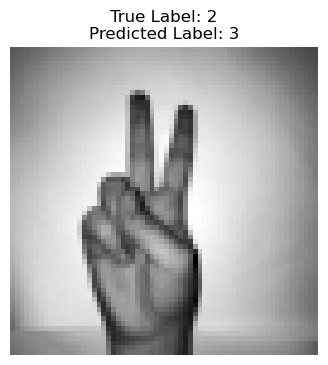

True Label: 2
Predicted Label: 3


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_image_and_predict(model, X, y, class_labels):
    # Select a random index from the training set
    random_index = np.random.randint(0, len(X))
    
    # Get the image and true label
    random_image = X[random_index]
    true_label = y[random_index]
    
    # Reshape the image if it's flattened
    if random_image.shape != (64, 64):
        random_image = random_image.reshape(64, 64)
    
    # Make a prediction using the model
    predicted = model.predict(random_image.reshape(1, -1))
    predicted_label = np.argmax(predicted)
    
    # Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(random_image, cmap='gray')
    plt.title(f"True Label: {class_labels[np.argmax(true_label)]}\nPredicted Label: {class_labels[predicted_label]}")
    plt.axis('off')
    plt.show()

    print(f"True Label: {class_labels[np.argmax(true_label)]}\nPredicted Label: {class_labels[predicted_label]}")
# Assuming you have a list of class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(y_test.shape)
# Call the function to display a random image and make a prediction
plot_random_image_and_predict(model, X_test, y_test, class_labels)

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets